## Multilayer Perceptron in Pytorch with Sigmoid Output and MSE Loss

### Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline

In [3]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

### Settings and Dataset

In [10]:
# -----------------
# SETTINGS
# -----------------
RANDOM_SEED = 1
BATCH_SIZE = 128
NUM_EPOCHS = 100
LEARNING_RATE = 0.1
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
# -----------------
# MNIST DATASET
# -----------------

# transforms.ToTensor() scales images to 0-1 range
train_dataset = datasets.MNIST(root='mnist',
               train=True,
               transform=transforms.ToTensor(),
               download=True)

test_dataset = datasets.MNIST(root='mnist',
               train=False,
               transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
           batch_size=BATCH_SIZE,
           shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
           batch_size=BATCH_SIZE,
           shuffle=False)

In [12]:
# Checking the dataset
for images, labels in train_loader:
    print("Shape of Feature Images: ", images.shape)
    print("Shape of Labeled Images: ", labels.shape)
    break

Shape of Feature Images:  torch.Size([128, 1, 28, 28])
Shape of Labeled Images:  torch.Size([128])


In [13]:
# This is manual way of computing one hot encoding.
# Unnessary Memory allocation
# Can use F.one_hot() instead  
def one_hot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    temp = y_onehot.view(-1, 1).long().to(DEVICE)
    y_onehot.scatter_(1, temp, 1).float()
    return y_onehot

In [14]:
NUM_CLASSES = len(labels.unique())

In [17]:
class MLPSigmoidMSE(torch.nn.Module):
    
    def __init__(self, num_features, num_hidden, num_classes):
        super(MLPSigmoidMSE, self).__init__()

        self.num_classes = num_classes

        self.linear_1 = torch.nn.Linear(num_features, num_hidden)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()

        self.linear_out = torch.nn.Linear(num_hidden, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()

    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        probs = torch.sigmoid(logits)
        return logits, probs

In [19]:
# --------------------
# Model Initialization
# --------------------

torch.manual_seed(RANDOM_SEED)
model = MLPSigmoidMSE(num_features=28*28, num_hidden=100, num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [28]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        features = features.view(-1, 28*28).to(DEVICE)

        logits, probs = model(features)

        y_onehot = F.one_hot(labels, model.num_classes).float().to(DEVICE)
        cost = F.mse_loss(y_onehot, probs)
        optimizer.zero_grad()

        cost.backward()
        minibatch_cost.append(cost.item())
        optimizer.step()

        if not batch_idx % 50:
            print(f"Epoch: {epoch+1:.03f}/{NUM_EPOCHS:.03f} | Batch: {batch_idx:.03f}/{len(train_loader):.03f} | Cost: {cost.item():.04f}")

    cost = torch.nn.MSELoss(model, train_loader) # Check this first if anything go wrong
    epoch_cost.append(cost)
    print(f"Epoch: {epoch+1:.03f}/{NUM_EPOCHS:.03f}")
    print(f"Time elapsed: {(time.time() - start_time) / 60:.02f}")

print(f"Total Training Time: {(time.time() - start_time) / 60:.02f} min")

Epoch: 1.000/100.000 | Batch: 0.000/469.000 | Cost: 0.0805
Epoch: 1.000/100.000 | Batch: 50.000/469.000 | Cost: 0.0798
Epoch: 1.000/100.000 | Batch: 100.000/469.000 | Cost: 0.0813
Epoch: 1.000/100.000 | Batch: 150.000/469.000 | Cost: 0.0804
Epoch: 1.000/100.000 | Batch: 200.000/469.000 | Cost: 0.0800
Epoch: 1.000/100.000 | Batch: 250.000/469.000 | Cost: 0.0788
Epoch: 1.000/100.000 | Batch: 300.000/469.000 | Cost: 0.0756
Epoch: 1.000/100.000 | Batch: 350.000/469.000 | Cost: 0.0771
Epoch: 1.000/100.000 | Batch: 400.000/469.000 | Cost: 0.0759
Epoch: 1.000/100.000 | Batch: 450.000/469.000 | Cost: 0.0761
Epoch: 1.000/100.000
Time elapsed: 0.10
Epoch: 2.000/100.000 | Batch: 0.000/469.000 | Cost: 0.0763
Epoch: 2.000/100.000 | Batch: 50.000/469.000 | Cost: 0.0751
Epoch: 2.000/100.000 | Batch: 100.000/469.000 | Cost: 0.0774
Epoch: 2.000/100.000 | Batch: 150.000/469.000 | Cost: 0.0748
Epoch: 2.000/100.000 | Batch: 200.000/469.000 | Cost: 0.0754
Epoch: 2.000/100.000 | Batch: 250.000/469.000 | Cos

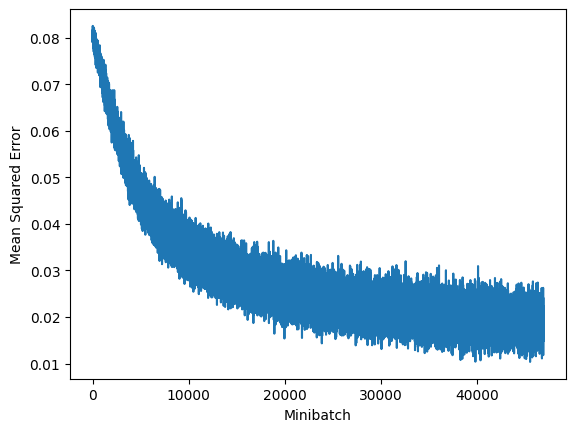

In [29]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel("Mean Squared Error")
plt.xlabel("Minibatch")
plt.show()

In [36]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            a1, a2 = net.forward(features)
            predicted_labels = torch.argmax(a2, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 90.28
Test Accuracy: 90.98


## Sigmoid activation + MSE has the problem of very flat gradients when the output is very wrong